→ Use Hierarchical Clustering. Why? <br>
1. Analyze which GMM clusters are similar, possibly merging noisy/small clusters. <br>
2. Visualize a dendrogram to explore nested structure. <br>
3. Exclude low-confidence points and compare high-confidence clusters. <br>


In [1]:
import torch

if torch.cuda.is_available():
    print("✅ GPU is available!")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("❌ GPU is NOT available.")

❌ GPU is NOT available.


Load the CSV and Inspect

In [ ]:
import pandas as pd

# Load the saved GMM output
df_clean = pd.read_csv('D:/Research/Papers/repo/IEEE_SubResizeUsingAIForFleetVehicles/Output/gmm_cluster_output_20250621_2318.csv')

# Check the first few rows
df_clean.head(5)

taxiid            timestamp  longitude  latitude      ts_num  cluster  \
0       2  2008-02-02 13:33:52  116.36422  39.88781  1201959232       14   
1       2  2008-02-02 13:37:16  116.37481  39.88782  1201959436       14   
2       2  2008-02-02 13:38:53  116.37677  39.88791  1201959533       14   
3       2  2008-02-02 13:42:18  116.38033  39.88795  1201959738       14   
4       2  2008-02-02 13:43:55  116.39392  39.89014  1201959835       14   

   is_outlier  gmm_cluster  gmm_cluster_confidence  
0           0            3                0.803400  
1           0            3                0.686885  
2           0            3                0.657319  
3           0            3                0.598102  
4           0            6                0.411855

Compute GMM Cluster Centroids<br>
Each row represents the centroid (mean) of all GPS points (lat/lon) that GMM assigned to that cluster.<br>
How Were These Centroids Computed? <br>
1. Latitude centroid = average latitude of all points in that GMM cluster <br>
2. Longitude centroid = average longitude of all points in that cluster <br>

why Centroids?<br>
1.Input to Hierarchical Clustering to find proximity between clusters.<br>
2.Reference points for mapping and labeling <br>

In [ ]:
# Filter for high-confidence points
df_high_conf = df_clean[df_clean['gmm_cluster_confidence'] >= 0.6]

# Group by GMM clusters to get centroid of each cluster
cluster_summary = df_high_conf.groupby('gmm_cluster').agg({
    'latitude': 'mean',
    'longitude': 'mean',
    'gmm_cluster_confidence': 'mean',
    'taxiid': 'nunique'
}).reset_index()

cluster_summary.rename(columns={'taxiid': 'unique_taxis'}, inplace=True)
print(cluster_summary)

   gmm_cluster   latitude   longitude  gmm_cluster_confidence  unique_taxis
0            0  39.980680  116.317662                0.739315           404
1            1  40.145604  117.134219                0.999646            54
2            2  39.904374  116.532177                0.833176           337
3            3  39.884750  116.332935                0.820066           460
4            4  39.800532  115.820036                0.985821             2
5            5  40.388904  116.805370                0.998841            61
6            6  39.885578  116.431631                0.752754           460
7            7  40.075399  116.580848                0.971345           314
8            8  40.496141  116.079435                1.000000            12
9            9  39.778498  116.104018                0.966636            97


Pairwise Distance<br>
1. Pairwise distance is the distance between every pair of cluster centroids.<br>
2. calculate the distance between each pair of these 10 centroids.<br>
**📏 Common distance metrics:**<br>
1.Euclidean<br>
2.Manhattan <br>
3.Cosine <br>


In [ ]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Compute pairwise distances
distance_matrix = pdist(cluster_summary[['latitude', 'longitude']], metric='euclidean')

Linkage <br>
It describes how distances between clusters are computed during merging.
🧮 Common methods:<br>
1-->Single linkage: minimum distance between elements of two clusters <br>
2-->Complete linkage: maximum distance <br>
3-->Average linkage: average distance <br>
4-->Ward’s method: minimizes variance (best for compact clusters)


In [ ]:
from scipy.cluster.hierarchy import linkage

# Compute linkage matrix
linked  = linkage(distance_matrix, method='ward')  # 'ward', 'average', 'single', 'complete'

Visualize Dendrogram <br>
why?<br>
How clusters are merged step-by-step in hierarchical clustering <br>
Which clusters are similar (merge earlier = more similar) <br>
The order of merging <br>
The distance (dissimilarity) at which clusters merge <br>

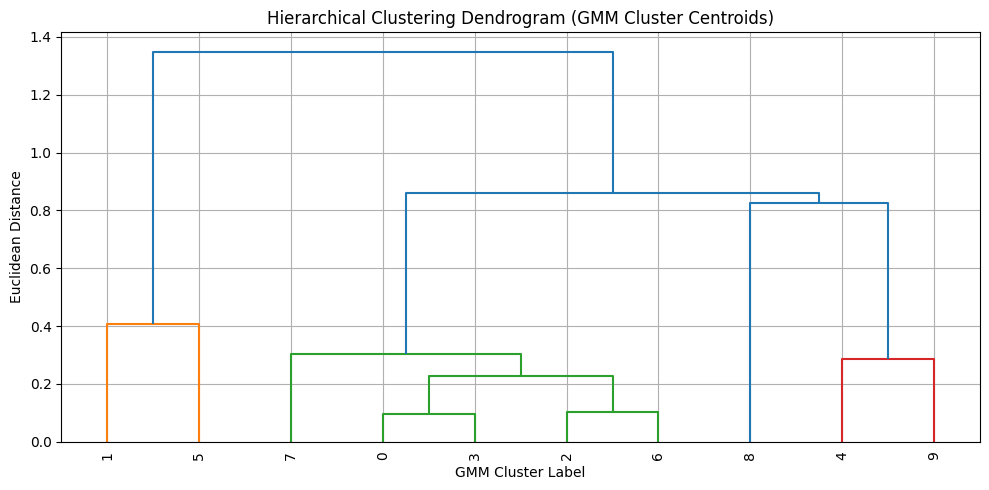

In [ ]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist

# 1. Compute pairwise distances (you already did this)
distance_matrix = pdist(cluster_summary[['latitude', 'longitude']], metric='euclidean')

# 2. Generate linkage matrix (Ward's method is good for compact clusters)
linkage_matrix = linkage(distance_matrix, method='ward')

# 3. Plot dendrogram
plt.figure(figsize=(10, 5))
dendrogram(
    linkage_matrix,
    labels=cluster_summary['gmm_cluster'].values,
    leaf_rotation=90,
    leaf_font_size=10,
    color_threshold=0.5 * max(linkage_matrix[:, 2])  # heuristic cut-off
)
plt.title("Hierarchical Clustering Dendrogram (GMM Cluster Centroids)")
plt.xlabel("GMM Cluster Label")
plt.ylabel("Euclidean Distance")
plt.grid(True)
plt.tight_layout()
plt.show()


**Hierarchical Clustering Dendrogram Summary**<br>
📊 Purpose:
This dendrogram illustrates the spatial relationships between 10 GMM clusters, based on the proximity of their centroid coordinates (latitude, longitude). It shows how clusters can be hierarchically merged based on geographic similarity.
**Label:** <br>
1.Leaf Nodes (Bottom Labels):Each number (e.g., 0, 1, 2, ..., 9) represents a GMM cluster label. These are the original clusters produced by Gaussian Mixture Model.<br>
2.Vertical Lines = Merge Distance:The height of each "Y" joint represents the Euclidean distance between the centroids of the merged clusters.<br>
----> A smaller height → clusters are very similar <br>
----> A larger height → clusters are farther apart <br>
**Most Similar Clusters:** <br>
1. 1 and 5 are merged at a very low distance (~0.4) → they are very spatially close.<br>
2. 3, 0, 2, 6, and 7 are tightly grouped into one branch → a natural macro-cluster. <br>
**Distant or Isolated Clusters:** <br>
1. 8, 4, and 9 form another group, but at a higher merge distance (~0.8–1.0).<br>
2. These are less similar to the other clusters, indicating they may represent more remote or outlier regions.<br>
**Final Merge Height:**
1. The top-most merge (≈1.35) combines two major branches.
2. This split gives a good cutoff point for forming macro-clusters.

### Grouping from This Dendrogram:
|Macro Cluster|Included GMM Clusters|
|:------|:-------|
|🟢 Cluster A|0, 2, 3, 6, 7|
|🔵 Cluster B|1, 5|
|🔴 Cluster C|4, 8, 9| <br>

This grouping lets you:<br>
1. Reduce 10 GMM 10 clusters to 3 manageable zones using Hierarchical Clustering based on centroid proximity <br>
2. Understand spatial affinity between clusters <br>
3. Apply subnet resizing logic at macro-cluster level <br>
4. Use macro-cluster labels as a feature for prediction <br>

Merge macro cluster data with full GMM dataset

In [ ]:
from scipy.cluster.hierarchy import linkage, fcluster
import pandas as pd
import numpy as np

# Assuming df_centroids contains the GMM centroids
# Columns: gmm_cluster, latitude, longitude
df_centroids = cluster_summary[['gmm_cluster', 'latitude', 'longitude']].copy()

# Step 1: Prepare features (only lat/lon)
X = df_centroids[['latitude', 'longitude']].values

# Step 2: Linkage matrix using Ward’s method
linkage_matrix = linkage(X, method='ward')

# Step 3: Form 3 macro-clusters
num_macro_clusters = 3
macro_labels = fcluster(linkage_matrix, num_macro_clusters, criterion='maxclust')

# Step 4: Map each GMM cluster to its macro-cluster
df_centroids['macro_cluster'] = macro_labels

if 'macro_cluster' in df_high_conf.columns:
    df_high_conf.drop(columns='macro_cluster', inplace=True)

# merge with full GMM dataset
df_high_conf = df_high_conf.merge(df_centroids[['gmm_cluster', 'macro_cluster']], on='gmm_cluster', how='left')
# df_high_conf.head(3)



In [ ]:
import plotly.express as px

fig = px.scatter_mapbox(
    df_high_conf,
    lat="latitude",
    lon="longitude",
    color="macro_cluster",
    zoom=7,
    mapbox_style="carto-positron",
    title="📍 Macro Clusters from Hierarchical Clustering (based on GMM Centroids)",
    height=600
)

fig.update_layout(
    margin={"r":0, "t":40, "l":0, "b":0},
    legend_title="Macro Cluster"
)

fig.show()


C:\Users\uif74417\AppData\Local\Temp\ipykernel_4248\1386496890.py:3: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



Save the output to csv

In [ ]:
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M")
filename = f"D:/Research/Papers/repo/IEEE_SubResizeUsingAIForFleetVehicles/Output/Hierarchical_clustering_output_{timestamp}.csv"
df_high_conf.to_csv(filename, index=False)